In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, freqz

In [2]:
# Load dataset
data = pd.read_csv('samples1.csv')

In [3]:
data

,Elapsed time,AECG1,AECG2,AECG3,AECG4
0,'0:00.000',-3.3,-6.7,3.0,-3.5
1,'0:00.001',-3.8,-6.7,3.0,-3.5
2,'0:00.002',-4.4,-6.8,3.2,-3.5
3,'0:00.003',-5.0,-6.9,3.2,-3.6
4,'0:00.004',-5.6,-6.9,3.3,-3.7
...,...,...,...,...,...
9995,'0:09.995',5.4,9.6,7.8,10.5
9996,'0:09.996',5.1,8.8,7.4,10.0
9997,'0:09.997',4.8,7.7,6.9,9.5
9998,'0:09.998',4.6,6.3,6.3,8.8


In [4]:
# Convert columns to float and handle NaN values
for column in ['AECG1', 'AECG2', 'AECG3', 'AECG4']:
    data[column] = pd.to_numeric(data[column], errors='coerce')  # Convert to numeric, set errors as NaN
    data[column].fillna(0, inplace=True)  # Replace NaN values with 0
    
# Convert 'Elapsed time' to minutes
data['Elapsed time'] = data['Elapsed time'].apply(lambda x: sum(float(t.replace("'", "")) * (60**i) for i, t in enumerate(reversed(x.split(":")))))


In [5]:
def bandpass_filter(data, lowcut=0.5, highcut=50.0, signal_freq=500, filter_order=1):
    nyquist = 0.5 * signal_freq
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(filter_order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

#excluding maternal ecg
def exclude_maternal_ecg(signal, qrs_peaks, window=100):
    excluded = np.array(signal)
    for peak in qrs_peaks:
        start = max(0, peak - window)
        end = min(len(signal) - 1, peak + window)
        excluded[start:end] = 0
    return excluded

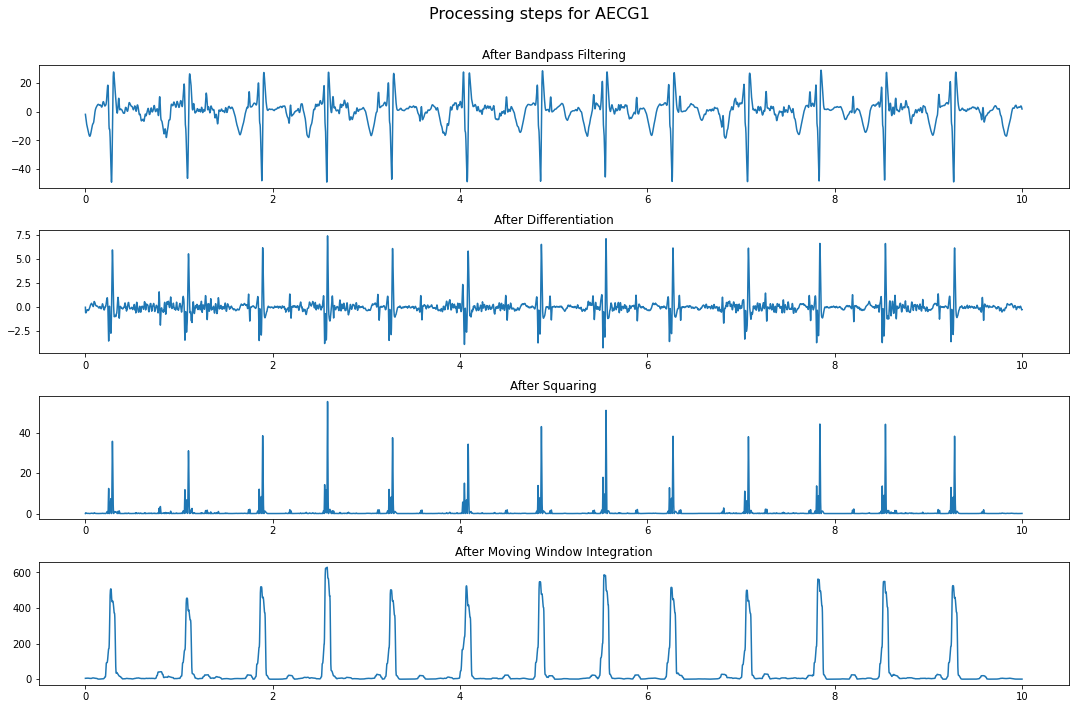

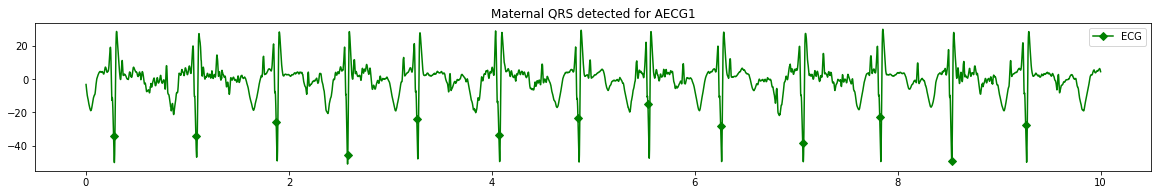

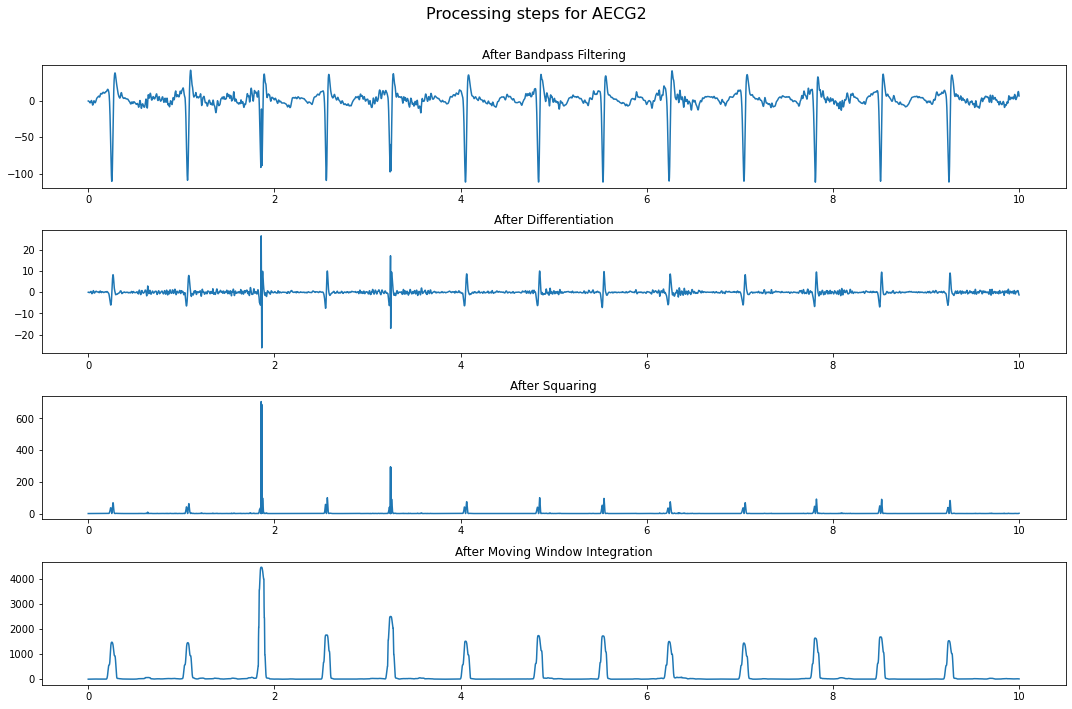

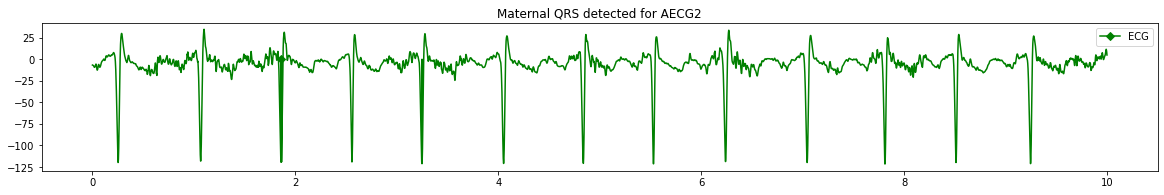

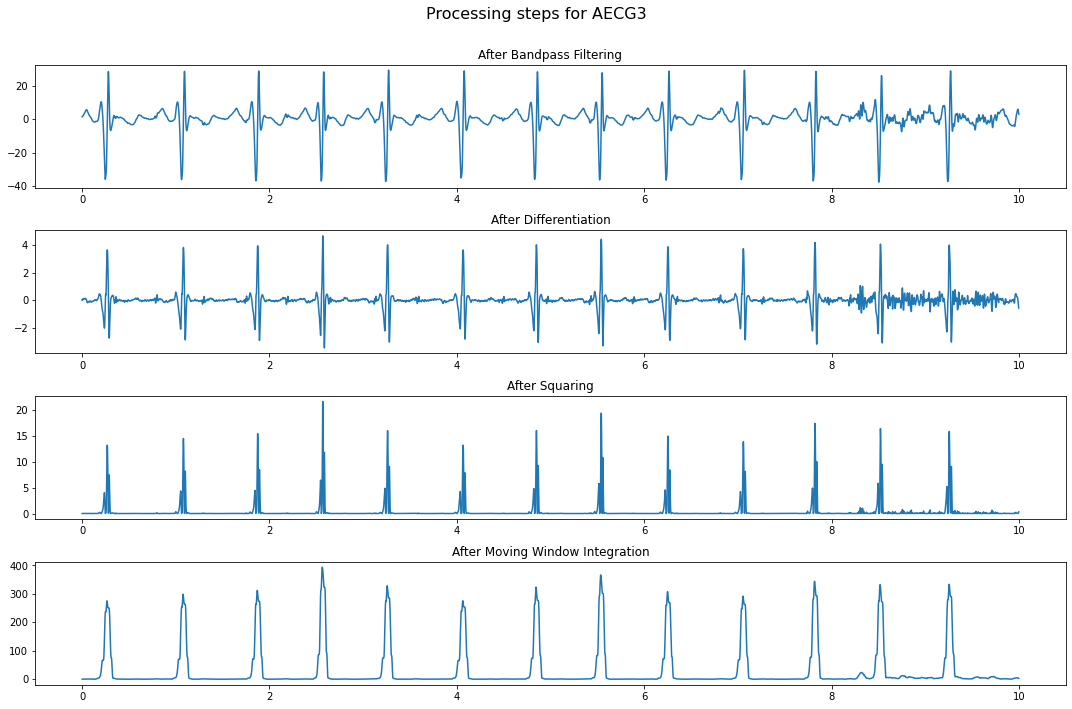

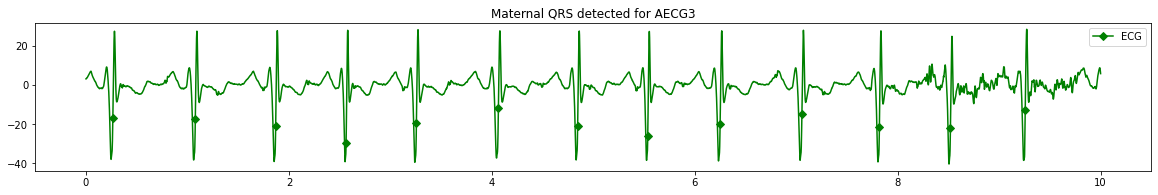

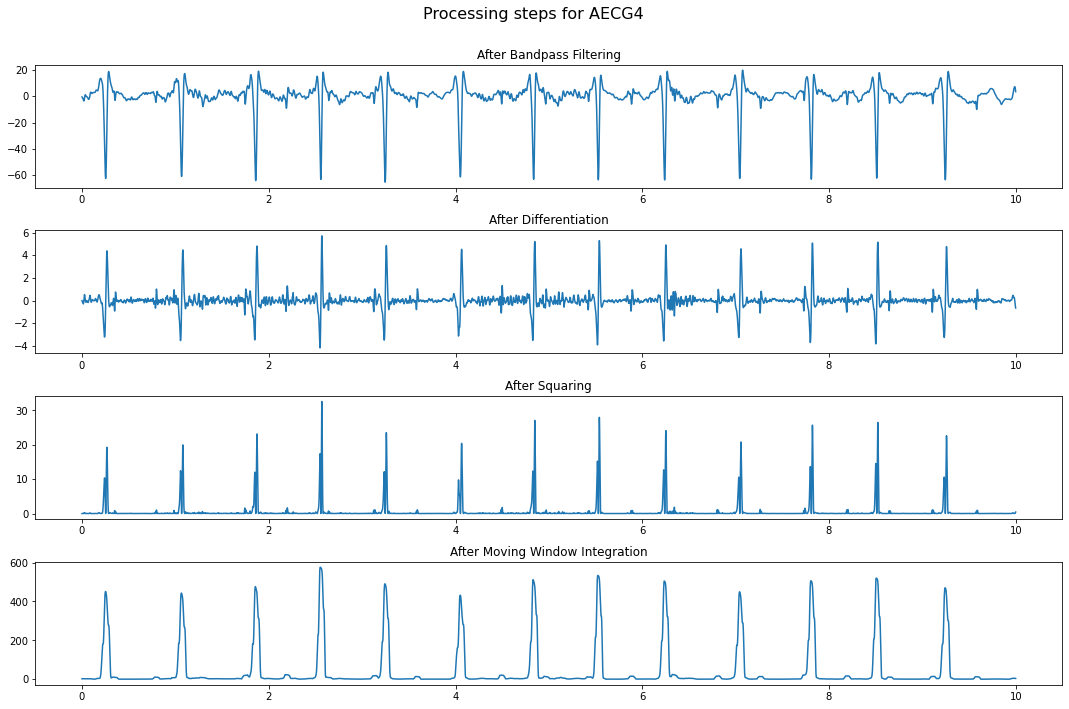

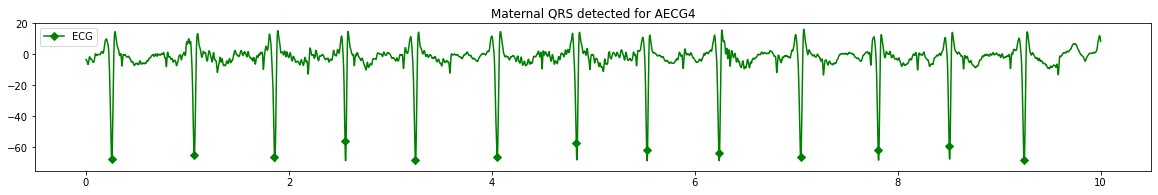

In [6]:
for column in ['AECG1', 'AECG2', 'AECG3', 'AECG4']:
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'Processing steps for {column}', fontsize=16)
    
    # 1. Bandpass filter
    ecg_bandpassed = bandpass_filter(data[column])
    plt.subplot(4, 1, 1)
    plt.plot(data['Elapsed time'], ecg_bandpassed)
    plt.title('After Bandpass Filtering')
    
    # 2. Differentiation
    differentiated = np.diff(ecg_bandpassed)
    differentiated = np.insert(differentiated, 0, 0)  # to keep the same length
    plt.subplot(4, 1, 2)
    plt.plot(data['Elapsed time'], differentiated)
    plt.title('After Differentiation')
    
    # 3. Squaring
    squared = differentiated ** 2
    plt.subplot(4, 1, 3)
    plt.plot(data['Elapsed time'], squared)
    plt.title('After Squaring')
    
    # 4. Moving window integration
    window = int(0.12 * 500)  # Assuming a sampling frequency of 500 Hz
    mwi = np.convolve(squared, np.ones(window), 'same')
    plt.subplot(4, 1, 4)
    plt.plot(data['Elapsed time'], mwi)
    plt.title('After Moving Window Integration')
    
    # Layout adjustments and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # to make space for the suptitle
    plt.show()
    
    # Thresholding and finding peaks
    threshold = 0.6 * np.max(mwi)
    peaks, _ = find_peaks(mwi, height=threshold, distance=window)
    
    # Assuming a sampling frequency of 500 Hz
    plt.figure(figsize=(20,6))
    
    # Plot the results
    plt.subplot(2, 1, 1)
    plt.title(f'Maternal QRS detected for {column}')
    plt.plot(data['Elapsed time'], data[column], '-gD', markevery=peaks.tolist())
    plt.legend(['ECG', 'QRS Peak'])
    
plt.show()


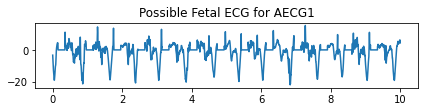

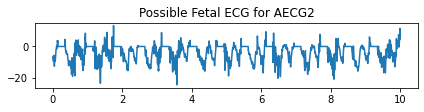

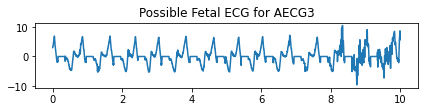

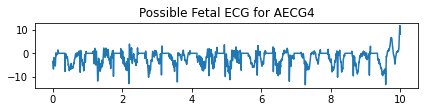

In [7]:
for column in ['AECG1', 'AECG2', 'AECG3', 'AECG4']:
    possible_fetal_ecg = exclude_maternal_ecg(data[column], peaks)

    plt.subplot(3, 1, 3)
    plt.title(f'Possible Fetal ECG for {column}')
    plt.plot(data['Elapsed time'], possible_fetal_ecg)
    plt.tight_layout()

    plt.show()